In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable 
import torchvision
from torchvision import transforms
from torch import utils
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
use_cuda

True

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from torch.utils import data

class Dataset(data.Dataset):
	'Characterizes a dataset for PyTorch'
	def __init__(self, features, labels):
		'Initialization'
		self.labels = labels
		self.features = features
    
	def __len__(self):
		'Denotes the total number of samples'
		return len(self.features)

	def __getitem__(self, index):
		'Generates one sample of data'
		x = self.features[index]
		y = self.labels[index]
		return x, y

In [0]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, n_hiden, first_hiden = 0, center_hiden = 0 , last_hiden = 2): 
        if first_hiden == 0:
            first_hiden = input_dim
        if center_hiden == 0:
            center_hiden = first_hiden
        super(LogisticRegressionModel, self).__init__()
        self.leyer_list = nn.ModuleList()
        layer_w = input_dim
        hiden_dim = first_hiden
        for i in range(n_hiden+1):
          self.leyer_list.append(nn.Linear(layer_w, hiden_dim))
          if i < (n_hiden/2)-1:
            layer_w = hiden_dim
            hiden_dim = (int)((i+1)*(2*(center_hiden-first_hiden)/n_hiden)+first_hiden)
          else:
            layer_w = hiden_dim
            hiden_dim = (int)((i-n_hiden/2+1)*(2*(last_hiden-center_hiden)/n_hiden)+center_hiden)
        self.leyer_list.append(nn.Linear(layer_w, 1))
    def forward(self, x): 
        Relu = nn.ReLU()
        Sigm = nn.Sigmoid()
        for layer in self.leyer_list[:-1]:
            x = Relu(layer(x))
        y = Sigm(self.leyer_list[-1](x))
        return y

In [0]:
def acc(features, targets, trained_model, criterion):
  targets = targets.to(device).view(-1,1).detach()
  outputs = trained_model(features.to(device)).detach()
  loss_eval = criterion(outputs, targets)
  pred = (outputs>0.5).float()
  pred = (pred.to(device) == targets).sum()
  return pred.float()/len(outputs), loss_eval.detach()

In [0]:
def plot_roc(X_test, y_test, trained_model):
  output = trained_model(X_test.to(device))
  fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), output.cpu().detach().numpy())
  plt.figure()
  lw = 2
  auc_val = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % auc_val)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()
  return auc_val

In [0]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["train_loss"]))
    ax[0].plot(x, run_hist["train_loss"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["test_loss"],'r', marker='.', label="test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["train_acc"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["test_acc"],'r', marker='.', label="test accuracy")
    ax[1].legend()

In [0]:
def train(model, stat_dict, training_generator, epochs, params, optimation, loss_fun, load_model = False, info=True):
  model.to(device)
  n_epoch = len(stat_dict["train_acc"])
  progres_bar = tqdm_notebook(range(n_epoch, epochs), leave=True)
  progres_bar.set_description('Treaning: ')
  for epoch in progres_bar:
      test_acc, test_loss = acc(X_test, y_test, model, loss_fun)
      if info:
        epoch_bar = tqdm_notebook(training_generator, leave=True)
        epoch_bar.set_description('\nEpoch {}/{}'.format(epoch+1, epochs))
      else:
        epoch_bar = training_generator
      train_acc, train_loss = 0, 0
      i = 0
      for features, targets in epoch_bar:
          i += 1
          optimation.zero_grad()
          features, targets = features.to(device).view(-1,input_dim), targets.to(device).view(-1,1)
          pred = model(features)
          loss = loss_fun(pred, targets)
          loss.backward()
          optimation.step()
          train_acc += ((pred.detach()>0.5).float().to(device) == targets).sum().float()/len(features)
          train_loss += loss.detach()
      train_loss /= i
      train_acc /= i
      stat_dict["test_loss"].append(test_loss)
      stat_dict["train_loss"].append(train_loss)
      stat_dict["test_acc"].append(test_acc)
      stat_dict["train_acc"].append(train_acc)
      torch.save(model.state_dict(), "/content/gdrive/My Drive/PITE/model{}_{}_{}_{}".format(*params))
      torch.save(stat_dict, "/content/gdrive/My Drive/PITE/state{}_{}_{}_{}".format(*params))
      if info:
        print("epoch {}, train_loss {}, train_accuracy = {}, test_loss {}, test_accuracy = {}".format(epoch+1, train_loss, train_acc, test_loss, test_acc))
  return model, stat_dict

In [0]:
train_data_file = "/content/gdrive/My Drive/PITE/data.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["is_true_seed","has_MCParticle",
                      "is_downstream_reconstructible",
                      "has_MCParticle_not_electron",
                     "is_downstream_reconstructible_not_electron",
                     "seed_mva_value"] , axis=1).astype(np.float64)
targets = data.is_downstream_reconstructible.values
featuresnp = features.drop(features.columns[0], axis=1).values

In [12]:
print(featuresnp)

[[ 1.44792874e+00  1.84910115e+03  1.08352274e+03 ... -1.43095899e+02
  -7.22092939e-01 -3.86714296e-02]
 [ 3.54944730e-01  1.00856228e+04  1.34514854e+03 ... -2.84193871e+02
  -1.29122137e-01 -3.79203554e-02]
 [ 2.90652352e+00  2.44153468e+03  1.01388841e+03 ... -2.70235334e+02
  -4.56234802e-01 -1.51978073e-02]
 ...
 [ 5.49376297e+00  1.21844956e+03  9.27026952e+02 ... -3.18414374e+02
  -1.17171352e+00 -3.95624097e-02]
 [ 6.95178340e+00  1.32173959e+03  9.63163094e+02 ...  2.12572602e+02
  -1.06405209e+00 -7.97020466e-03]
 [ 3.93933640e+00  2.54141187e+03  1.14446986e+03 ...  1.15643206e+03
   4.69775485e-01  1.83560605e-01]]


In [0]:
scaler = StandardScaler()
scaler.fit(featuresnp)
X = scaler.transform(featuresnp)
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size = 0.1)

In [0]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [0]:
epochs = 150
batch_size = 20000
input_dim = X.shape[1]
output_dim = 1
lr_rate = 0.01
n_hiden = 14
first_hiden = 90
center_hiden = 70
last_hiden = 15
params = [n_hiden, first_hiden, center_hiden, last_hiden]
training_set = Dataset(X_train, y_train)
training_generator = utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True)

n_hiden: 14, first_hiden: 90, center_hiden: 70 last_hiden: 15


epoch 101, train_loss 0.28741252422332764, train_accuracy = 0.8839799165725708, test_loss 0.27374744415283203, test_accuracy = 0.8896778225898743


epoch 102, train_loss 0.275263249874115, train_accuracy = 0.8885902166366577, test_loss 0.2776300013065338, test_accuracy = 0.8882204294204712


epoch 103, train_loss 0.2734820246696472, train_accuracy = 0.8893464207649231, test_loss 0.27625566720962524, test_accuracy = 0.8884729743003845


epoch 104, train_loss 0.2736993432044983, train_accuracy = 0.8893679976463318, test_loss 0.2769148349761963, test_accuracy = 0.8882783651351929


epoch 105, train_loss 0.2732858657836914, train_accuracy = 0.8894912004470825, test_loss 0.2764241099357605, test_accuracy = 0.8885019421577454


epoch 106, train_loss 0.27335506677627563, train_accuracy = 0.8894071578979492, test_loss 0.2759779393672943, test_accuracy = 0.8887379765510559


epoch 107, train_loss 0.2734549045562744, train_accuracy = 0.889399528503418, test_loss 0.2778507173061371, test_accuracy = 0.8881458640098572


epoch 108, train_loss 0.2731625437736511, train_accuracy = 0.8894955515861511, test_loss 0.276140421628952, test_accuracy = 0.8886095881462097


epoch 109, train_loss 0.27329593896865845, train_accuracy = 0.8894993662834167, test_loss 0.27542445063591003, test_accuracy = 0.8896364569664001


epoch 110, train_loss 0.2732926607131958, train_accuracy = 0.889396071434021, test_loss 0.2771322429180145, test_accuracy = 0.8885102272033691


epoch 111, train_loss 0.2732688784599304, train_accuracy = 0.8894695043563843, test_loss 0.27633342146873474, test_accuracy = 0.8888745903968811


epoch 112, train_loss 0.27318450808525085, train_accuracy = 0.8895658254623413, test_loss 0.2767041027545929, test_accuracy = 0.8885889053344727


epoch 113, train_loss 0.27389490604400635, train_accuracy = 0.8893359303474426, test_loss 0.27732911705970764, test_accuracy = 0.8881831169128418


epoch 114, train_loss 0.2736210227012634, train_accuracy = 0.8893142342567444, test_loss 0.2795566916465759, test_accuracy = 0.8875786662101746


epoch 115, train_loss 0.27311691641807556, train_accuracy = 0.88957279920578, test_loss 0.276347279548645, test_accuracy = 0.8889366984367371


epoch 116, train_loss 0.2735043466091156, train_accuracy = 0.8894439339637756, test_loss 0.2762376368045807, test_accuracy = 0.8885309100151062


epoch 117, train_loss 0.27271154522895813, train_accuracy = 0.8898249268531799, test_loss 0.27638131380081177, test_accuracy = 0.8887959122657776


epoch 118, train_loss 0.2750419080257416, train_accuracy = 0.8887465000152588, test_loss 0.27609825134277344, test_accuracy = 0.8890898823738098


epoch 119, train_loss 0.27444028854370117, train_accuracy = 0.8889989256858826, test_loss 0.28292572498321533, test_accuracy = 0.8858355283737183


epoch 120, train_loss 0.27320653200149536, train_accuracy = 0.8895651698112488, test_loss 0.27762076258659363, test_accuracy = 0.8880962133407593


epoch 121, train_loss 0.2744241952896118, train_accuracy = 0.889024019241333, test_loss 0.27659302949905396, test_accuracy = 0.8887338042259216


epoch 122, train_loss 0.2731849253177643, train_accuracy = 0.8895594477653503, test_loss 0.27847349643707275, test_accuracy = 0.8874958157539368


epoch 123, train_loss 0.2724890410900116, train_accuracy = 0.8897486329078674, test_loss 0.27646300196647644, test_accuracy = 0.8883528709411621


epoch 124, train_loss 0.27173981070518494, train_accuracy = 0.8901810050010681, test_loss 0.27720770239830017, test_accuracy = 0.8887420892715454


epoch 125, train_loss 0.2724643051624298, train_accuracy = 0.8898702263832092, test_loss 0.2766907215118408, test_accuracy = 0.8884067535400391


epoch 126, train_loss 0.27150213718414307, train_accuracy = 0.8902595043182373, test_loss 0.27642565965652466, test_accuracy = 0.8882742524147034


epoch 127, train_loss 0.27189868688583374, train_accuracy = 0.8901861906051636, test_loss 0.2761622369289398, test_accuracy = 0.8888745903968811


epoch 128, train_loss 0.2720348536968231, train_accuracy = 0.8899818062782288, test_loss 0.27953970432281494, test_accuracy = 0.8872473835945129


epoch 129, train_loss 0.2725895345211029, train_accuracy = 0.8898213505744934, test_loss 0.27625802159309387, test_accuracy = 0.8886013031005859


epoch 130, train_loss 0.27264833450317383, train_accuracy = 0.8898840546607971, test_loss 0.2778865098953247, test_accuracy = 0.888249397277832


epoch 131, train_loss 0.27183997631073, train_accuracy = 0.8902369141578674, test_loss 0.27732324600219727, test_accuracy = 0.8886716961860657


epoch 132, train_loss 0.2722319960594177, train_accuracy = 0.8899902105331421, test_loss 0.27685731649398804, test_accuracy = 0.8888828754425049


epoch 133, train_loss 0.27218201756477356, train_accuracy = 0.8900392055511475, test_loss 0.279799222946167, test_accuracy = 0.8868291974067688


epoch 134, train_loss 0.27221056818962097, train_accuracy = 0.8899194598197937, test_loss 0.27691763639450073, test_accuracy = 0.8880547881126404


epoch 135, train_loss 0.2732776701450348, train_accuracy = 0.8896878957748413, test_loss 0.27702078223228455, test_accuracy = 0.8887214064598083


epoch 136, train_loss 0.27159595489501953, train_accuracy = 0.8902324438095093, test_loss 0.27666598558425903, test_accuracy = 0.88853919506073


epoch 137, train_loss 0.28119564056396484, train_accuracy = 0.8863130211830139, test_loss 0.2759714424610138, test_accuracy = 0.8887007236480713


epoch 138, train_loss 0.28457072377204895, train_accuracy = 0.8840962052345276, test_loss 0.29406610131263733, test_accuracy = 0.8802293539047241


epoch 139, train_loss 0.27997177839279175, train_accuracy = 0.8862996697425842, test_loss 0.28694283962249756, test_accuracy = 0.8836203813552856


epoch 140, train_loss 0.27945607900619507, train_accuracy = 0.8866935968399048, test_loss 0.28297945857048035, test_accuracy = 0.8858893513679504


epoch 141, train_loss 0.2772936224937439, train_accuracy = 0.8876438736915588, test_loss 0.2837127447128296, test_accuracy = 0.885603666305542


epoch 142, train_loss 0.27570584416389465, train_accuracy = 0.8884268999099731, test_loss 0.28126049041748047, test_accuracy = 0.8863323926925659


epoch 143, train_loss 0.27536091208457947, train_accuracy = 0.888512134552002, test_loss 0.2801847457885742, test_accuracy = 0.8873385190963745


epoch 144, train_loss 0.27466198801994324, train_accuracy = 0.8887445330619812, test_loss 0.28007516264915466, test_accuracy = 0.8873302340507507


epoch 145, train_loss 0.2744936943054199, train_accuracy = 0.8887945413589478, test_loss 0.2789174020290375, test_accuracy = 0.8874585628509521


epoch 146, train_loss 0.275190532207489, train_accuracy = 0.8883621096611023, test_loss 0.2794676125049591, test_accuracy = 0.8875662088394165


epoch 147, train_loss 0.27367112040519714, train_accuracy = 0.8893274068832397, test_loss 0.27998465299606323, test_accuracy = 0.8872018456459045


epoch 148, train_loss 0.27306756377220154, train_accuracy = 0.8895780444145203, test_loss 0.2783307135105133, test_accuracy = 0.8879305720329285


epoch 149, train_loss 0.2732241749763489, train_accuracy = 0.8895826935768127, test_loss 0.2786438763141632, test_accuracy = 0.8876117467880249


epoch 150, train_loss 0.27603814005851746, train_accuracy = 0.8882964849472046, test_loss 0.27892187237739563, test_accuracy = 0.8877442479133606



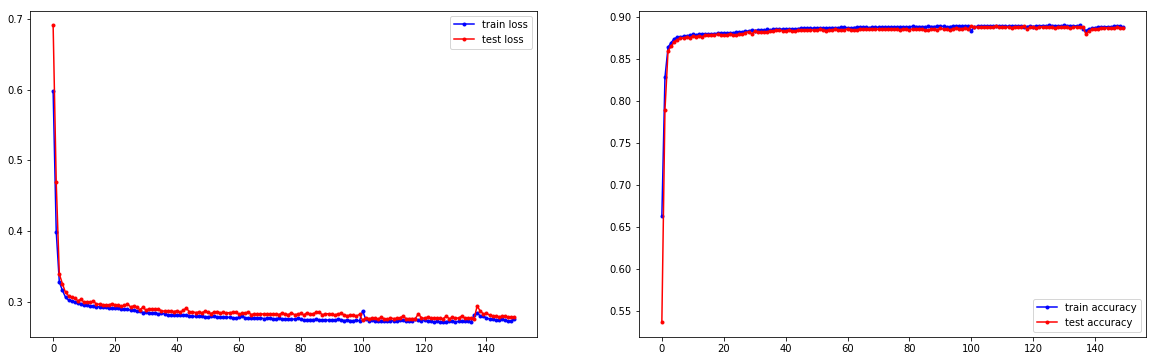

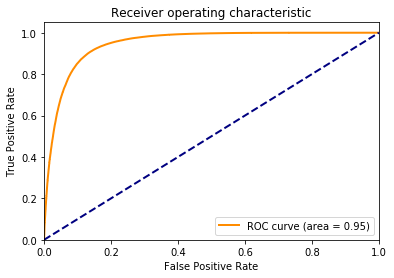

In [16]:
load_model = True
if load_model:
  model = LogisticRegressionModel(input_dim, *params)
  model.load_state_dict(torch.load("/content/gdrive/My Drive/PITE/model{}_{}_{}_{}".format(*params)))
  stat_dict = torch.load("/content/gdrive/My Drive/PITE/state{}_{}_{}_{}".format(*params))
else:
  model = LogisticRegressionModel(input_dim, *params)
  print(model)
  stat_dict = {
      "train_loss" : [],
      "test_loss" : [],
      "train_acc" : [],
      "test_acc" : []
  }
print("n_hiden: {}, first_hiden: {}, center_hiden: {} last_hiden: {}".format(*params))
loss_fn = torch.nn.BCELoss().to(device)
optimator = torch.optim.Adam(model.parameters(), lr_rate)
model, stat = train(model, stat_dict, training_generator, epochs, params, optimator, loss_fn)
if model != 0:
  plot_training_classification(stat)
  auc_val = plot_roc(X_test, y_test, model)